In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importation des librairies**

In [2]:
import os
import shutil
import re
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## **Définition des variables**

Chemin d'accès aux fichiers

In [3]:
path_drive = '/content/drive/Shareddrives/Projet_Deep_Learning_ING3' # chemin d'accès au Drive partagé
path_train = os.path.join(path_drive, 'Train') # chemin d'accès aux dossiers d'entraînement
path_test = os.path.join(path_drive, 'Test') # chemin d'accès aux dossiers de test

## **Prétraitement des images**

Lecture des images et redimensionnement de celles-ci

In [4]:
def get_matrixes(path_directory):

    # On définit le tableau qui va contenir toutes les matrices associés à leurs noms
    matrixes = []

    # On itère sur les sous-dossier de la racine : ils correspondent chacun à une classe
    for subdir in tqdm(os.listdir(path_directory)):

        # On définit subdir_path contenant le chemin absolue du sous-dossier courant
        subdir_path = os.path.join(path_directory, subdir)
    
        # On itère sur chacune des images contenues dans le sous-dossier courant
        for img in os.listdir(subdir_path):

            # On définit image_path contenant le chemin absolu de l'image courante
            img_path = os.path.join(subdir_path, img)

            # On lit l'image
            image = Image.open(img_path) # On récupère l'image via son chemin d'accès
            
            # On redimensionne l'image
            image = image.resize((192, 384)) # On redimensionne l'image pour lui donner une taille de 192 par 384 pixels
            image2 = image.rotate(180)
            # On transforme l'image en une matrice numpy
            matrix = np.asarray(image)
            matrix2 = np.asarray(image2)

            # On convertit la matrice en une matrice d'entiers codés sur un octet
            matrix.astype('uint8')
            matrix2.astype('uint8')
            
            # On ajoute la matrice au tableau des matrices
            matrixes.append((img, matrix))
            matrixes.append((img, matrix2))
    # On renvoie la liste des matrices
    return matrixes

In [6]:
train_matrixes = get_matrixes(path_train)
test_matrixes = get_matrixes(path_test)

100%|██████████| 11/11 [01:21<00:00,  7.38s/it]


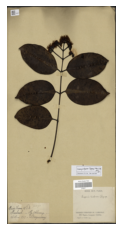

In [9]:
# On affiche la première image
plt.imshow(train_matrixes[0][1])
plt.axis('off')
plt.show()

Nettoyage des images

In [10]:
def clean_matrixes(matrixes):

    # On définit le tableau qui va contenir les matrices nettoyées
    cleaned_matrixes = []

    # On itère sur les sous-dossier de la racine : ils correspondent chacun à une classe
    for data in tqdm(matrixes):
        
        # On récupère la matrice
        matrix = data[1]

        # On récupère la dimension de la matrice
        w, h, _ = matrix.shape

        # On définit la matrice qui correspond à la version nettoyée de la matrice courantes
        cleaned_matrix = matrix.copy()

        # On itère sur les lignes
        for i in range(w):

            # On itère sur les colonnes
            for j in range(h):

                # On récupère le pixel courant
                pixel = matrix[i,j,:]
                
                # On vérifit si le pixel est accepté ou non
                # Pour cela, on définit une relation d'ordre sur les pixels : pixel1 <= pixel2 si et seulement si 
                #   • pixel1[0] <= pixel2[0]
                #   • pixel1[1] <= pixel2[1]
                #   • pixel1[2] <= pixel2[2]
                # Si le pixel est borné entre les pixels [ 30  30  10] et [130 130 100], on l'accepte car il est considéré comme un pixel de feuille
                # Si le pixel ne vérifie pas la condition ci-dessus, il devient un pixel blanc
                if 30 <= pixel[0] <= 130 and 30 <= pixel[1] <= 130 and 10 <= pixel[2] <= 100: # si le pixel est accepté...
                    cleaned_matrix[i,j,:] = pixel # ...on l'affecte à la bonne place dans la matrice nettoyée
                else: # si le pixel n'est pas accepté...
                    cleaned_matrix[i, j, 0] = cleaned_matrix[i, j, 1] = cleaned_matrix[i, j, 2] = 255 # ...on remplace les sous pixel par les composantes du blanc
        
        # On convertit la matrice en une matrice d'entiers codés sur un octet
        cleaned_matrix.astype('uint8')

        # On ajoute la matrice nettoyée à la liste des matrices nettoyées
        cleaned_matrixes.append((data[0], cleaned_matrix))

    # On renvoie la liste des matrices nettoyées
    return cleaned_matrixes

In [11]:
train_matrixes = clean_matrixes(train_matrixes)
test_matrixes = clean_matrixes(test_matrixes)

100%|██████████| 220/220 [01:46<00:00,  2.08it/s]


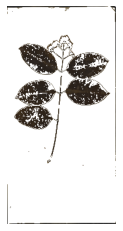

In [14]:
# On affiche la première image
plt.imshow(train_matrixes[0][1])
plt.axis('off')
plt.show()

## **Sauvegarde des images**

In [15]:
def save_cleaned_images(matrixes, path_directory):
    
    # On vérifit si le répertoire existe ou non
    if not os.path.exists(path_directory): # Si le répertoire n'existe pas...
        os.mkdir(path_directory) # ...On le crée

    # On vérifit si le répertoire est vide ou non
    if os.listdir(path_directory) != []: # Si le répertoire n'est pas vide
        shutil.rmtree(path_directory)

    # On itère sur les matrices associées à chacune des images de plante
    for image_name, matrix in tqdm(matrixes): 
        
        # On récupère l'espèce de la plante
        species = re.sub('[0-9]{3}.jpg', '', image_name)
        
        # On construit le chemin su répertoire associé à l'espèce de plante
        subdir_path = os.path.join(path_directory, species)

        # On vérifit si le répertoire existe ou non
        if not os.path.exists(subdir_path): # Si le répertoire n'existe pas...
            os.mkdir(subdir_path) # ...On le crée

        # On transforme la matrice en une image
        image = Image.fromarray(matrix)

        # On sauvegarde l'image
        image.save(os.path.join(subdir_path, image_name))

In [16]:
save_cleaned_images(train_matrixes, os.path.join(path_drive, 'Augemented_Train'))
save_cleaned_images(test_matrixes, os.path.join(path_drive, 'Augmented_Test'))

100%|██████████| 220/220 [00:01<00:00, 123.82it/s]
